### Using S&P 500 Historical Data to Predict Bitcoin Investment Return

In this analysis, we attempt to examine S&P 500 historical data and determine if such data can be used to predict return on future Bitcoin investments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data Collection and Labeling

In [2]:
coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)
coin_df.drop('Symbol', axis=1, inplace=True)
coin_df.drop('Name', axis=1, inplace=True)

coin_df.head()

,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
# Add a classification column. The class of each data point is determined by the percent change in close price
# day by day
coin_df['Return'] = coin_df['Close'].pct_change()
# First row in df has NaN 'return' since there is no previous day
coin_df.drop(coin_df.index[0], inplace=True)
coin_df.head()

,High,Low,Open,Close,Volume,Marketcap,Return
Date,,,,,,,
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,-0.038328
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,-0.158345
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,-0.100692
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,-0.070906
2013-05-04,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,0.150895


In [4]:
# Next we read in S&P 500 Dataset
sp_df = pd.read_csv('index_data/sp_500_historical.csv')
new_column_names = {
    "Close/Last": "Close"
}
sp_df.rename(columns=new_column_names, inplace=True)

sp_df.index = pd.to_datetime(sp_df['Date']).dt.date
sp_df.index = pd.DatetimeIndex(sp_df.index)

sp_df.drop('Date', axis=1, inplace=True)
# Drop Volume too. There are no non '--' values for Volume
sp_df.drop('Volume', axis=1, inplace=True)

# The S&P 500 Dataframe appears to be backwards. Let's reverse it so that it is more in line with out coin set
# This probably doesn't matter, but just in case.
sp_df = sp_df.reindex(index=sp_df.index[::-1])
sp_df.head()

,Close,Open,High,Low
Date,,,,
2011-03-29,1319.44,1310.19,1319.45,1305.26
2011-03-30,1328.26,1319.44,1331.74,1321.89
2011-03-31,1325.83,1328.26,1329.77,1325.03
2011-04-01,1332.41,1325.83,1337.85,1328.89
2011-04-04,1332.87,1332.41,1336.74,1329.10


In [5]:
# We now need to preprocess our data some more. We need to make sure that the dates in our dataframes appear in both
coin_dates = set(coin_df.index)
sp_dates = set(sp_df.index)
shared_dates = sp_dates.intersection(coin_dates)

for date in sp_dates.difference(shared_dates):
    sp_df.drop(date, inplace=True)
for date in coin_dates.difference(shared_dates):
    coin_df.drop(date, inplace=True)

print(len(coin_df))
print(len(sp_df))

1995
1995


In [6]:
sp_df['Return'] = coin_df['Return']


# Some rows of the sp_df have bad data (such as columns with a value of 0 that skew the data). So we drop these
sp_df = sp_df[sp_df['Close'] != 0]
sp_df = sp_df[sp_df['Open'] != 0]
sp_df = sp_df[sp_df['High'] != 0]
sp_df = sp_df[sp_df['Low'] != 0]

sp_df.head()

,Close,Open,High,Low,Return
Date,,,,,
2013-04-30,1597.57,1593.58,1597.57,1586.50,-0.038328
2013-05-01,1582.70,1597.55,1597.55,1581.28,-0.158345
2013-05-02,1597.59,1582.77,1598.60,1582.77,-0.100692
2013-05-03,1614.42,1597.60,1618.46,1597.60,-0.070906
2013-05-06,1617.50,1614.40,1619.77,1614.21,-0.031145


### Data Visualization

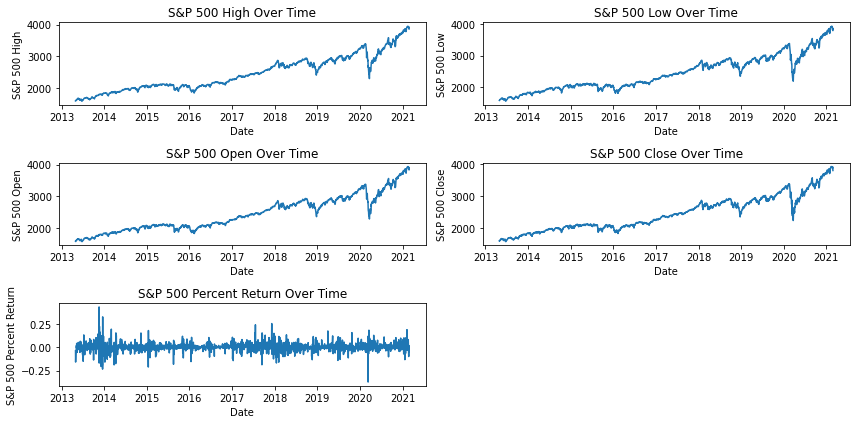

In [7]:
# A basic visualization of Date vs the coin_df columns
fig = plt.figure(figsize=(12, 6))

# High over time
high_axis = fig.add_subplot(3, 2, 1)
high_axis.plot(sp_df.index, sp_df['High'])
high_axis.set_title('S&P 500 High Over Time')
high_axis.set_xlabel('Date')
high_axis.set_ylabel('S&P 500 High')

# Low over time
low_axis = fig.add_subplot(3, 2, 2)
low_axis.plot(sp_df.index, sp_df['Low'])
low_axis.set_title('S&P 500 Low Over Time')
low_axis.set_xlabel('Date')
low_axis.set_ylabel('S&P 500 Low')

# Open over time
open_axis = fig.add_subplot(3, 2, 3)
open_axis.plot(sp_df.index, sp_df['Open'])
open_axis.set_title('S&P 500 Open Over Time')
open_axis.set_xlabel('Date')
open_axis.set_ylabel('S&P 500 Open')

# Close over time
close_axis = fig.add_subplot(3, 2, 4)
close_axis.plot(sp_df.index, sp_df['Close'])
close_axis.set_title('S&P 500 Close Over Time')
close_axis.set_xlabel('Date')
close_axis.set_ylabel('S&P 500 Close')

# Return over time
return_axis = fig.add_subplot(3, 2, 5)
return_axis.plot(sp_df.index, sp_df['Return'])
return_axis.set_title('S&P 500 Percent Return Over Time')
return_axis.set_xlabel('Date')
return_axis.set_ylabel('S&P 500 Percent Return')

plt.tight_layout()
plt.show()

---

### Class Assignment

In [8]:
# Sentiment on return: 
# > .10 then very good 0 < < 0.10 then good converse for bad and very bad
def get_sentiment(return_val):
    if return_val >= 0.10:
        return 'very good'
    elif return_val > 0 and return_val < 0.10:
        return 'good'
    elif return_val <= 0 and return_val > -0.10:
        return 'bad'
    elif return_val <= -0.10:
        return 'very bad'
    else:
        print(return_val)
        return None
# Replace Return column with label
sp_df['Return'] = [get_sentiment(return_val) for return_val in sp_df['Return']]
sp_df.head()

,Close,Open,High,Low,Return
Date,,,,,
2013-04-30,1597.57,1593.58,1597.57,1586.50,bad
2013-05-01,1582.70,1597.55,1597.55,1581.28,very bad
2013-05-02,1597.59,1582.77,1598.60,1582.77,very bad
2013-05-03,1614.42,1597.60,1618.46,1597.60,bad
2013-05-06,1617.50,1614.40,1619.77,1614.21,bad


In [9]:
# We are faced with a new problem: Class Imbalance. This will be addressed in the next section
class_counts = {}
for class_ in sp_df['Return']:
    class_counts[class_] = class_counts.get(class_, 0) + 1
print(class_counts)

{'bad': 871, 'very bad': 42, 'good': 1005, 'very good': 54}


---

### Model Evaluation/Parameter Tuning

In the next few code blocks, we deal with Class Imbalance issues, and evaluate multiple models with fine-tuned parameters.

In [10]:
# To decide on the best model, we should fine tune the parameters of the models in consideration to see
# the best performances of our models.

# Here, we use a StandardScaler on Vix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X = sp_df[['Open', 'High', 'Low', 'Close']]
y = sp_df['Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

### Class Imbalance

As we saw above, the number of "good" vs "bad" data points heavily outweigh the "very good" and "very bad" data points. In the next cell, we attempt to assign class weights to account for this disparity.

In [11]:
# We should now deal with the issue of class_weights
from sklearn.utils import class_weight
labels = np.unique(y_train)
class_weights = dict(zip(labels, class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

{'bad': 0.5655737704918032, 'good': 0.4907539118065434, 'very bad': 11.129032258064516, 'very good': 9.583333333333334}


### Logistic Regression Evaluation

In [12]:
# Logistic Regression Parameter Tuning
from sklearn.linear_model import LogisticRegression
param_grid = {  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                }

lr = LogisticRegression(max_iter=2000, class_weight=class_weights)
grid = GridSearchCV(lr, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
lr_best_params = grid.best_params_

Best grid score: 0.21
Grid test score: 0.24
Best grid parameters: {'C': 100}


### Decision Tree Evaluation

In [13]:
# Decision Tree Parameter Tuning
from sklearn.tree import DecisionTreeClassifier
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12,14,16,18,20,25,30,40,50,70]
}
dt = DecisionTreeClassifier(class_weight=class_weights)
grid = GridSearchCV(dt, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
dt_best_params = grid.best_params_

Best grid score: 0.49
Grid test score: 0.48
Best grid parameters: {'criterion': 'entropy', 'max_depth': 50}


### KNN Evaluation

In [14]:
# K-Nearest Neighbors Parameter Tuning
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier() # No class_weight param
grid = GridSearchCV(knn, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
knn_best_params = grid.best_params_

Best grid score: 0.52
Grid test score: 0.46
Best grid parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


### SVC Evaluation

In [15]:
# SVC Parameter Tuning
from sklearn.svm import SVC
param_grid = {
    'C':[1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
}
svc = SVC(class_weight=class_weights)
grid = GridSearchCV(svc, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
svc_best_params = grid.best_params_

Best grid score: 0.37
Grid test score: 0.34
Best grid parameters: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


### Retraining with Best Parameters


In [17]:
# Let's retrain the models using the fine-tuned parameters found
# so we can examine the confusion matrix and scoring report and make a conclusion.
lr = LogisticRegression(max_iter=2000, C=lr_best_params['C'], class_weight=class_weights)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('Logistic Regression Score: {:.2f}'.format(lr.score(X_test, y_test)))

dt = DecisionTreeClassifier(criterion=dt_best_params['criterion'], max_depth=dt_best_params['max_depth'], class_weight=class_weights)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print('Decision Tree Score: {:.2f}'.format(dt.score(X_test, y_test)))

knn = KNeighborsClassifier(metric=knn_best_params['metric'], n_neighbors=knn_best_params['n_neighbors'], weights=knn_best_params['weights'])
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('KNN Score: {:.2f}'.format(knn.score(X_test, y_test)))

svc = SVC(C=svc_best_params['C'], gamma=svc_best_params['gamma'], kernel=svc_best_params['kernel'], class_weight=class_weights)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('SVC Score: {:.2f}'.format(svc.score(X_test, y_test)))

Logistic Regression Score: 0.24
Decision Tree Score: 0.49
KNN Score: 0.46
SVC Score: 0.34


---

### Score Reporting

Here, we take a closer look at the performance of our models, as raw accuracy is often not a great indicator.

### Confusion Matrices

In [18]:
from sklearn.metrics import confusion_matrix
labels = ["Bad", "Good", "Very Good", "Very Bad"]
print("Logistic Regression Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, lr_pred), index=labels, columns=labels), '\n')
print("Decision Tree Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, dt_pred), index=labels, columns=labels), '\n')
print("KNN Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, knn_pred), index=labels, columns=labels), '\n')
print("SVC Classifier Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, svc_pred), index=labels, columns=labels), '\n')

Logistic Regression Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad         55    55         88        63
Good        50    77        115        60
Very Good    1     3          6         1
Very Bad     1     5          6         6 

Decision Tree Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        113   144          2         2
Good       112   172          7        11
Very Good    3     8          0         0
Very Bad     7     8          0         3 

KNN Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        106   155          0         0
Good       134   168          0         0
Very Good    3     8          0         0
Very Bad     8    10          0         0 

SVC Classifier Confusion Matrix:
           Bad  Good  Very Good  Very Bad
Bad        105    67         50        39
Good       128    89         43        42
Very Good    1     2          4         4
Very Bad     5     2          5         6 



### Classification Reports (f1-score, precision, accuracy, etc.)

In [19]:
from sklearn.metrics import classification_report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred), '\n')
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, dt_pred), '\n')
print("KNN Classifier Classification Report:")
print(classification_report(y_test, knn_pred), '\n')
print("SVC Classifier Classification Report:")
print(classification_report(y_test, svc_pred), '\n')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         bad       0.51      0.21      0.30       261
        good       0.55      0.25      0.35       302
    very bad       0.03      0.55      0.05        11
   very good       0.05      0.33      0.08        18

    accuracy                           0.24       592
   macro avg       0.28      0.34      0.20       592
weighted avg       0.51      0.24      0.31       592
 

Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

         bad       0.48      0.43      0.46       261
        good       0.52      0.57      0.54       302
    very bad       0.00      0.00      0.00        11
   very good       0.19      0.17      0.18        18

    accuracy                           0.49       592
   macro avg       0.30      0.29      0.29       592
weighted avg       0.48      0.49      0.48       592
 

KNN Classifier Classification Repor

/Users/richie/I513/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/richie/I513/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/richie/I513/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Interpretation of Metrics

Here, we can see that the classifiers we have constructed do not serve as good predictors for the trend we are attempting to observe. With f1-scores of near 0, we can see that the estimators fail to predict the class correctly for data points with "very good" and "very bad" classes. Because of the lack of promise here, we can say that the S&P 500 is likely not a good estimator for Bitcoin return. 